In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 1. Data Preprocessing and Feature Engineering

## Clean and Prepare

In [2]:
df = pd.read_csv('../data/ads_all_cleaned.csv')

### Missing Values

One missing value in title which we will ignore

In [3]:
df.isnull().sum()

id                  0
num_of_pic          0
price               0
brand               0
model               0
title               1
year                0
km                  0
steering_side       0
region_specs        0
location            0
location_cleaned    0
dtype: int64

### Outliers

I will choose to keep outliers.

## Feature Engineering

Below is the wordcloud that was generated in the data analysis phase in the ads_all_after_cleaning.html report

Some of the more common words which could be useful are **warranty**, **accident** (to determine ads where there is specific mention that the car is accident free), **service** (to indicate a full service history) 

![wordcloud](../data/title-column-wordcloud.png)

In [4]:
# Feature Engineering
df['warranty'] = df['title'].apply(lambda x: True if 'warranty' in str(x).lower() else False)
df['service_hist'] = df['title'].apply(lambda x: True if 'service' in str(x).lower() else False)
df['no_accident'] = df['title'].apply(lambda x: True if 'accident' in str(x).lower() else False)

luxury_brands = ['mercedez-benz','lexus','bmw','audi']
df['luxury'] = df['brand'].apply(lambda x: 1 if x.lower() in luxury_brands else 0)

df['age'] = 2024 - df['year']

df.drop(['id','title','year','location'], axis=1, inplace=True)


## Data Preprocessing

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define feature columns
categorical_features = ['brand','model','steering_side','region_specs','location_cleaned']
numerical_features = ['km','age','num_of_pic']
binary_features = ['warranty', 'service_hist', 'no_accident','luxury']

# Preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=False))
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', binary_transformer, binary_features)
    ])

In [6]:
X = df.drop('price', axis=1)
y = df['price']

In [7]:
X

,num_of_pic,brand,model,km,steering_side,region_specs,location_cleaned,warranty,service_hist,no_accident,luxury,age
0,17,Ford,F-Series Pickup,107000,Left Hand,GCC Specs,Dubai,False,True,False,0,6
1,18,Ford,Mustang,2000,Left Hand,American Specs,Sharjah,True,False,False,0,3
2,19,Ford,Edge,79000,Left Hand,GCC Specs,Dubai,False,True,False,0,8
3,19,Ford,Mustang,55000,Left Hand,GCC Specs,Dubai,True,True,False,0,4
4,19,Ford,Mustang,29000,Left Hand,GCC Specs,Dubai,True,True,False,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
20867,20,Volkswagen,Passat,107624,Left Hand,GCC Specs,Dubai,False,True,False,0,10
20868,17,Volkswagen,Tiguan,0,Left Hand,Chinese Specs,Dubai,False,False,False,0,1
20869,17,Volkswagen,Transporter,0,Left Hand,GCC Specs,Dubai,False,False,False,0,5
20870,17,Volkswagen,Touareg,54300,Left Hand,GCC Specs,Dubai,False,False,False,0,3


In [8]:
y

0        159000
1        276000
2         62500
3        169000
4        209000
          ...  
20867     26000
20868    110000
20869     79000
20870    185000
20871     57000
Name: price, Length: 20872, dtype: int64

In [9]:
# train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=0)

# 2. Model Selection and Evaluation

In [13]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime

# Define the models
models = {
    'linear_regression': LinearRegression(),
    'svm': LinearSVR(max_iter=1000),
    'random_forest': RandomForestRegressor(),
    'gradient_boosted_rf': HistGradientBoostingRegressor(),
    'xgboost': xgb.XGBRegressor(),
    'lightgbm': lgb.LGBMRegressor()
}

def train_models(models):
    # Dictionary to hold the results
    results = {
        'model': [],
        'MAE': [],
        'R2': [],
        'training_time': []
    }

    cv_scores = {}

    # Iterate over the models
    for model_name, model in models.items():
        # Create pipeline with preprocessor and model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        train_start = datetime.now()
        pipeline.fit(X_train, y_train)
        train_stop = datetime.now()
        train_time = train_stop - train_start

        y_pred = pipeline.predict(X_test)

        # Perform k-fold cross-validation
        cv_score = cross_val_score(pipeline, X, y, cv=10, scoring='neg_mean_absolute_error')

        cv_scores[model_name] = -cv_score
        
        # Calculate the mean MAE score across folds
        mean_mae = -cv_score.mean()
        
        # Collect the results
        results['model'].append(model_name)
        results['MAE'].append(mean_mae)
        results['R2'].append(r2_score(y_test, y_pred))
        results['training_time'].append(train_time.total_seconds())  # Convert to seconds for easier readability

    return results, cv_scores
    
results, cv_scores = train_models(models)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results).set_index('model')

# Display the DataFrame
results_df


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 4174, number of used features: 95
[LightGBM] [Info] Start training from score 152932.704121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 18784, number of used features: 205
[LightGBM] [Info] Start training from score 159069.433667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

,MAE,R2,training_time
model,,,
linear_regression,2.561224e+15,-2.766232e+19,0.183931
svm,1.154593e+05,-1.397115e-01,0.053570
random_forest,4.529903e+04,3.155712e-01,13.378369
gradient_boosted_rf,6.021069e+04,2.844169e-01,4.246120
xgboost,4.726217e+04,3.432632e-01,0.373919
lightgbm,5.568950e+04,2.797819e-01,0.194122


Linear regression doesn't handle the data well since I chose not to remove outliers. The others seem to have done pretty well.

Linear Regression also gives some extremely high errors so I chose to remove them from the plot below.

Seems that the lowest error we get is around the k=2 mark. I propose to change the k value to either 4 or 6 for better results.

SVM definetly is a terrible fit so no point in moving forward with that.

<Axes: >

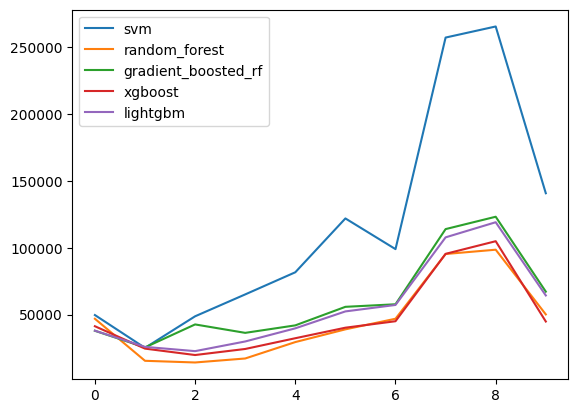

In [14]:
model_training = pd.DataFrame(cv_scores).iloc[:,1:]
model_training.plot(kind='line')